In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/combined_data.csv')
df.head(10)

,tanggal,isu,tonality,berita_jakarta,link/page
0,2019-08-01,Nasib DKI Jakarta Setelah Ibu Kota Pindah ke K...,NETRAL,NaN,NaN
1,2019-08-01,Integrasi Transportasi Oleh Jaklingko,POSITIF,Musyawarah Kerja Daerah Organda Jakarta Anies ...,https://www.beritajakarta.id/read/70758/musyaw...
2,2019-08-01,Integrasi Transportasi Oleh Jaklingko,POSITIF,Warga Apresiasi Pengoperasian Dua Jak Lingko d...,https://www.beritajakarta.id/read/70829/warga-...
3,2019-08-01,Pengelolaan Sampah Jakarta vs Surabaya,NETRAL,NaN,NaN
4,2019-08-02,Sidang Perdana Polusi Udara,NETRAL,Dishub Ingin Penggunaan Kendaraan Listrik Lebi...,https://www.beritajakarta.id/read/70807/dewan-...
5,2019-08-02,Sidang Perdana Polusi Udara,NETRAL,Pemprov DKI-ICLEI Sepakati Kerja Sama Penuruna...,https://www.beritajakarta.id/read/70819/pempro...
6,2019-08-02,Sidang Perdana Polusi Udara,NETRAL,Terbitkan Ingub Pemprov DKI Siapkan 7 Inisiati...,https://www.beritajakarta.id/read/70850/terbit...
7,2019-08-02,Sidang Perdana Polusi Udara,NETRAL,DKI Matangkan Aplikasi Pemantauan Kualitas Udara,https://www.beritajakarta.id/read/70888/dki-ma...
8,2019-08-02,Sidang Perdana Polusi Udara,NETRAL,Dewan Dukung Percepatan Pengoperasian Bus List...,https://www.beritajakarta.id/read/70814/dishub...
9,2019-08-02,Bantuan untuk Pencari Suaka Dihentikan,NETRAL,NaN,NaN


In [ ]:
df.tail(10)

In [ ]:
kategori = pd.get_dummies(df.tonality)
df = pd.concat([df, kategori], axis=1)
df = df.drop(columns='tonality')
df.sample(5)

,tanggal,isu,berita_jakarta,link/page,NEGATIF,NETRAL,NETRAL,POSITIF
1152,2019-01-18,Anies Minta Proyek NCICD Dikaji Ulang,NaN,NaN,0,1,0,0
832,2020-12-11,Larangan Perayaan Malam Tahun Baru 2021,Kebijakan Larangan Perayaan Tahun Baru Berpote...,https://www.beritajakarta.id/read/85484/kebija...,0,0,0,1
1549,2019-07-12,Tanggapan Kemen LHK Atas Kualitas Udara Ibukota,Pelaksanaan Uji Emisi Tahap Dua di Kantor Walk...,https://www.beritajakarta.id/read/70316/pelaks...,0,1,0,0
2026,2019-03-22,Penataan Trotoar di Kawasan Prioritas DKI Jakarta,NaN,NaN,0,0,0,1
245,2020-08-07,Evaluasi Pemberlakuan Kebijakan Ganjil Genap,Penumpang Transjakarta Meningkat Tujuh Persen,https://www.beritajakarta.id/read/81932/penump...,0,1,0,0


In [ ]:
feature = df['isu']
label = df[['NEGATIF', 'NETRAL', 'POSITIF']].values

In [ ]:
from sklearn.model_selection import train_test_split
feature_latih, feature_test, label_latih, label_test = train_test_split(feature, label, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


pad_type = 'pre'
trunc_type = 'pre'

# Tokenize our training data
tokenizer = Tokenizer(num_words=2000, oov_token='x')
tokenizer.fit_on_texts(feature_latih)
tokenizer.fit_on_texts(feature_test)

# Encode training data sentences into sequences
sekuens_latih = tokenizer.texts_to_sequences(feature_latih)
sekuens_test = tokenizer.texts_to_sequences(feature_test)

# Get max training sequence length
maxlen = max([len(x) for x in sekuens_latih])

# Pad the training sequences
padded_latih = pad_sequences(sekuens_latih, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
padded_test = pad_sequences(sekuens_test, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=2000, output_dim=8),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
  ])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           16000     
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 9

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 40
hist = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    verbose=2, callbacks=[callbacks])

Epoch 1/40
95/95 - 5s - loss: 0.9176 - accuracy: 0.5511 - val_loss: 0.8098 - val_accuracy: 0.6100 - 5s/epoch - 51ms/step
Epoch 2/40
95/95 - 1s - loss: 0.8289 - accuracy: 0.5848 - val_loss: 0.7768 - val_accuracy: 0.6100 - 1s/epoch - 12ms/step
Epoch 3/40
95/95 - 1s - loss: 0.7295 - accuracy: 0.6161 - val_loss: 0.6761 - val_accuracy: 0.7694 - 1s/epoch - 14ms/step
Epoch 4/40
95/95 - 2s - loss: 0.5857 - accuracy: 0.7470 - val_loss: 0.5086 - val_accuracy: 0.8024 - 2s/epoch - 19ms/step
Epoch 5/40
95/95 - 1s - loss: 0.4470 - accuracy: 0.8443 - val_loss: 0.4415 - val_accuracy: 0.8235 - 1s/epoch - 13ms/step
Epoch 6/40
95/95 - 1s - loss: 0.3504 - accuracy: 0.8750 - val_loss: 0.3857 - val_accuracy: 0.8867 - 1s/epoch - 11ms/step
Epoch 7/40
95/95 - 1s - loss: 0.2712 - accuracy: 0.9090 - val_loss: 0.3714 - val_accuracy: 0.8920 - 1s/epoch - 11ms/step
Epoch 8/40
95/95 - 1s - loss: 0.2314 - accuracy: 0.9248 - val_loss: 0.3692 - val_accuracy: 0.8999 - 1s/epoch - 11ms/step
Epoch 9/40

Akurasi telah mencap

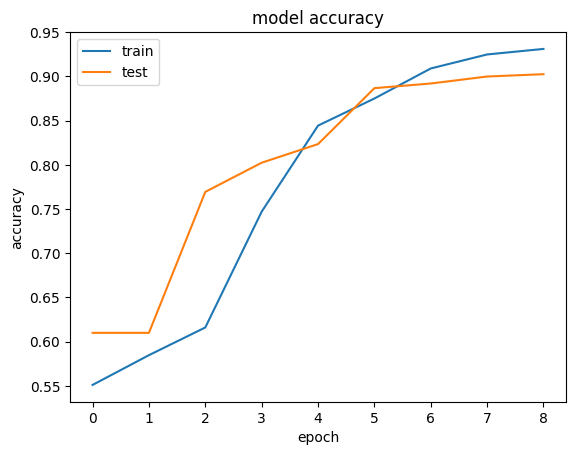

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

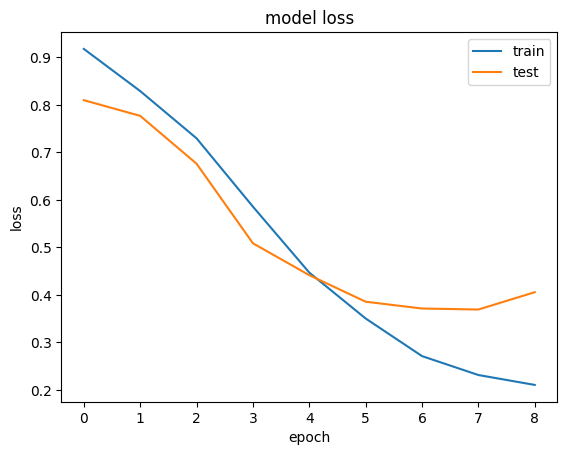

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# function to make predictions
def make_predictions(model, tokenizer, ml):
  classes = ['Negatif', 'Netral', 'Positif']
  while True:
    text = input('Masukkan isu berita: ')
    text = [text]
    t = tokenizer.texts_to_sequences(text)
    t = pad_sequences(t, padding='pre', truncating='pre', maxlen=ml)
    pred_t = model.predict(t)
    print('Prediksi: ', classes[pred_t.argmax()])
    lagi = input('Apakah ingin mencoba lagi? (y/n) :')
    if lagi=='n' or lagi=='N':
      break

make_predictions(model, tokenizer, maxlen)

1/1 [==============================] - 1s 601ms/step
Prediksi:  Netral
1/1 [==============================] - 0s 23ms/step
Prediksi:  Netral
